### Prezentacja problemu

Celem projektu jest zbadanie, czy algorytmy genetyczne mogą posłużyć do dobrania optymalnych hiperparametrów dla sieci neuronowej. W przypadku tego projektu sieć ma postać perceptronu wielowarstwowego składającego się z jednej warstwy wejściowej (embedding layer), kilku warstw ukrytych i normalizacyjnych oraz jednej warstwy wyjściowej. \
Przykładowa architektura może wyglądać np. tak:

nn.Embedding(vocab_size, n_embd), nn.Flatten() \
nn.Linear(n_embd * block_size, n_hidden, bias), norm_layer(n_hidden), activation_func \
nn.Linear(n_hidden, n_hidden, bias),            norm_layer(n_hidden), activation_func \
nn.Linear(n_hidden, n_hidden, bias),            norm_layer(n_hidden), activation_func \
nn.Linear(n_hidden, n_hidden, bias),            norm_layer(n_hidden), activation_func \
nn.Linear(n_hidden, vocab_size, bias),          norm_layer(vocab_size) \
nn.Softmax(vocab_size) 

Wszystkie modele zostały wytrenowane i przetestowane na zbiorze 32033 imion. Zadaniem perceptronu jest przewidzenie kolejnego znaku w sekwencji na podstawie trzech poprzednich tokenów. 

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt 
import random 
import math
import numpy as np
import pygad
import time

Przygotowanie danych:

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
vocab_size = len(inx_to_str)

# build the dataset
random.shuffle(words)
block_size = 3 # context length
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1


X, Y = torch.tensor(X), torch.tensor(Y)

# data set splits: train 80%, dev 10%, test 10%
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

In [3]:
@torch.no_grad() # disable gradient tracking
def get_loss(model, data_set):
    model.eval()
    x, y = {
        'train': (training_set, y_training_set),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item()

Inputami w tym eksperymencie będzie 9 modeli o różnej liczbie warst ukrytych.

In [4]:
# trzy inputy duże 
class MLP0(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits


class MLP1(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    

class MLP2(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    
# trzy inputy średnie
class MLP3(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    

class MLP4(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )
        
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    

class MLP5(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    
#trzy inputy małe
class MLP6(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    

class MLP7(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    

class MLP8(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    

inputs = [MLP0, MLP1, MLP2, MLP3, MLP4, MLP5, MLP6, MLP7, MLP8]

### Eksperyment 1

Geny znajdujące się w chromosomie:
* **n_embd** - długość vector embedding (wektorów wstawieniowych???) dla pojedyńczego tokenu. \
Możliwe wartości: 
    * 8
    * 16
    * 32
* **n_hidden** - ilość neuronów w warstwie ukrytej. \
Możliwe wartości:
    * dowolna liczba całkowita z przedziału [16, 80]
* **norm_layer** - typ warstwy normalizacyjnej. \
Możliwe wartości:
    * BatchNorm
    * LayerNorm
* **activation_func** - funkcja aktywacji. \
Możliwe wartości:
    * ReLU
    * Tanh
    * LeakyReLU
    * Sigmoid
* **lr** - wspólczynnik uczenia. \
Możliwe wartości:
    * 0.0001
    * 0.001
    * 0.005
    * 0.01
    * 0.1
* **batch_size** - wielkość batcha. \
Możliwe wartości:
    * 16
    * 32
    * 64
* **optimizer** - optymalizator. \
Możliwe wartości:
    * Adam
    * SGD

Przykładowy chromosom może wyglądać następująco: \
| n_embd | n_hidden | norm_layer | activation_func | lr | batch_size | optimizer | 
| --- | --- | --- | --- | --- | --- | --- |
|32 | 53 | BatchNorm | Tanh | 0.01 | 64 | SDG |  

\*wartości nieliczbowe w programie są zakodowane jako liczby całkowite

#### Funkcja Fitness

Funkcja fitness tworzy model o hiperparametrach podanych w chromosomie i trenuje stworzony model przez 1 epokę. Następnie obliczana jest wartość funkcji straty (przy użyciu funkcji CrossEntropy). Funkcja fitness zwraca wartość postaci: 
* **1.0 / (loss(*zbiór ewaluacyjny*) + 1e-8)** 

W tym przypadku dążymy do tego aby loss(zbiór ewaluacyjny) był jak najmniejszy, ale funkcja fitness szuka maksimum. Z tego powodu 1.0 musi znaleźć się w liczniku. Zbiór wartości funkcji to \(0, 100000000\]

#### Parametry i działanie algorytmu genetycznego

* num_generations = 15 
* num_parents_mating = 4
* sol_per_pop = 7
* mutation_num_genes = 1
* keep_elitism = 2
* parent_selection_type = "rws" 
* crossover_type = "single_point"

W każdej generacji wybierane są dwa chromosomy o najlepszym fitnessie, które na pewno znajdą się w kolejnej populacji. Następnie, rodzice wybierani są przy pomocy algorytmu "rws" (tzn. im lepszą wartość funkcji fitness ma rodzic, tym większe są jego szanse na zostanie wybranym). Krzyżowanie zachodzi w jednym, losowo wybranym punkcie chromosomu aż do uzyskania wymaganej liczby członków populacji. Losowa mutacja została ustawiona na jeden gen.
Wielkość generacji wynosi 15 (w przypadku dostępu do większych mocy obliczeniowych ta wartość powinna być większa). 

In [5]:
# mappings - encoding the hyperparameters as integers
optim_map = {
    0: torch.optim.Adam,
    1: torch.optim.SGD,
}

act_map = {
    0: torch.nn.ReLU(),
    1: torch.nn.Tanh(),
    2: torch.nn.LeakyReLU(),
    3: torch.nn.Sigmoid(),
}

norm_map = {
    0: torch.nn.BatchNorm1d,
    1: torch.nn.LayerNorm,
}


In [6]:
def fitness_func_factory(inp_model):
    def fitness_func(solution, sol_idx):
        n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = solution
        bias = True if int(norm_layer_num) == 1 else False
        activation = act_map[activation_num]
        norm_layer = norm_map[norm_layer_num]
        
        model = inp_model(vocab_size, int(n_embd), int(n_hidden), bias, norm_layer, activation)

        optimizer = optim_map[optimizer_num](params=model.parameters(), lr=lr)

        loss_function = torch.nn.CrossEntropyLoss()
        g = torch.Generator().manual_seed(2147483647)
        steps = 5704
        for _ in range(steps):
            inx = torch.randint(0, training_set.shape[0], (int(batch_size),), generator=g)
            emb = training_set[inx] # grab only those rows from the minibatch 

            optimizer.zero_grad(set_to_none=True)

            # forward pass
            preds = model(emb)
            loss = loss_function(preds, y_training_set[inx])

            # backward pass
            loss.backward()

            # update the weights
            optimizer.step()
            
        dev_loss = get_loss(model, 'dev')
        return 1.0 / (dev_loss + 1e-8)
    
    return fitness_func

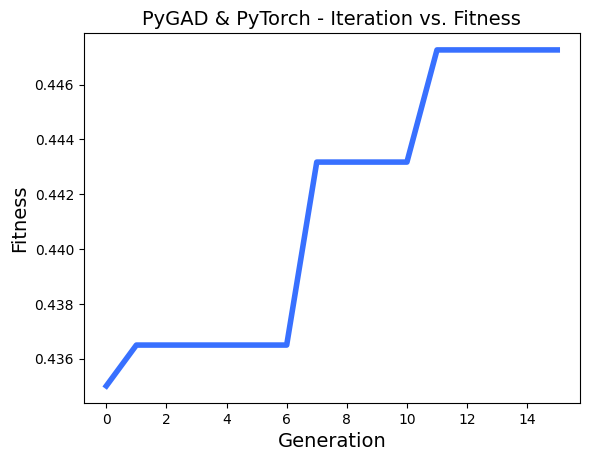

Best solution of MLP0 - number of hidden layers: 10: 
n_embd = 32.0
n_hidden = 79.0
norm_layer = <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
activation = ReLU()
lr = 0.001 
batch_size = 64.0
optimizer = <class 'torch.optim.adam.Adam'>


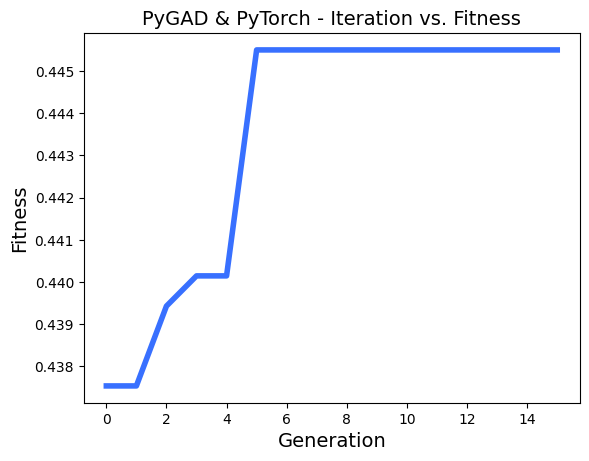

Best solution of MLP1 - number of hidden layers: 9: 
n_embd = 32.0
n_hidden = 64.0
norm_layer = <class 'torch.nn.modules.normalization.LayerNorm'>
activation = Tanh()
lr = 0.01 
batch_size = 64.0
optimizer = <class 'torch.optim.sgd.SGD'>


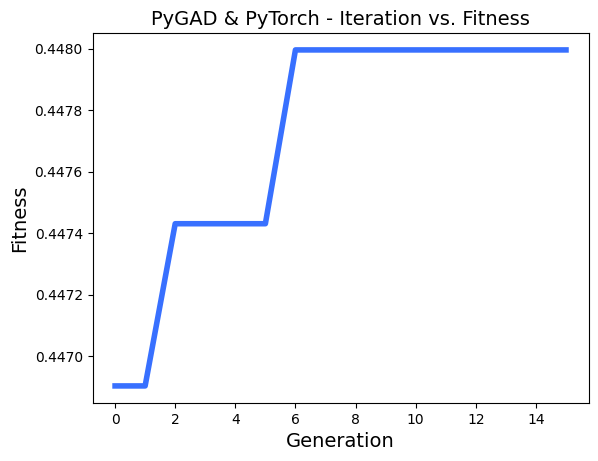

Best solution of MLP2 - number of hidden layers: 8: 
n_embd = 8.0
n_hidden = 61.0
norm_layer = <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
activation = LeakyReLU(negative_slope=0.01)
lr = 0.1 
batch_size = 64.0
optimizer = <class 'torch.optim.sgd.SGD'>


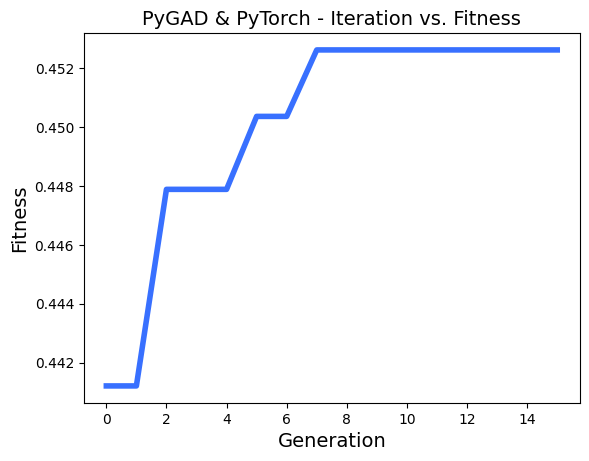

Best solution of MLP3 - number of hidden layers: 7: 
n_embd = 32.0
n_hidden = 75.0
norm_layer = <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
activation = LeakyReLU(negative_slope=0.01)
lr = 0.001 
batch_size = 64.0
optimizer = <class 'torch.optim.adam.Adam'>


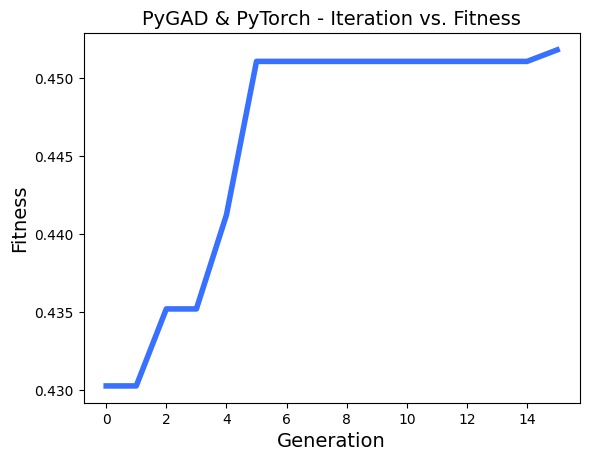

Best solution of MLP4 - number of hidden layers: 6: 
n_embd = 32.0
n_hidden = 59.0
norm_layer = <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
activation = ReLU()
lr = 0.1 
batch_size = 64.0
optimizer = <class 'torch.optim.sgd.SGD'>


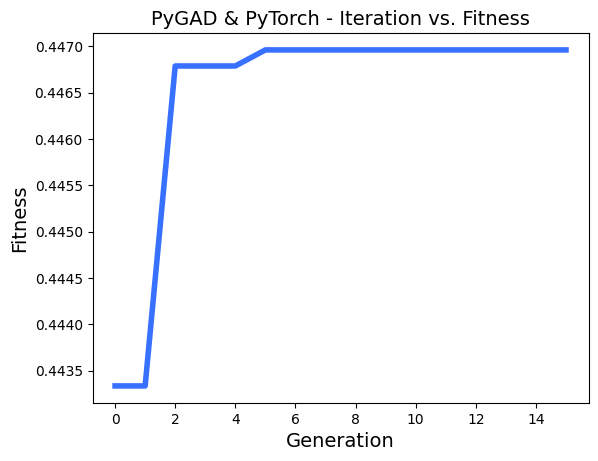

Best solution of MLP5 - number of hidden layers: 5: 
n_embd = 32.0
n_hidden = 68.0
norm_layer = <class 'torch.nn.modules.normalization.LayerNorm'>
activation = Tanh()
lr = 0.01 
batch_size = 64.0
optimizer = <class 'torch.optim.sgd.SGD'>


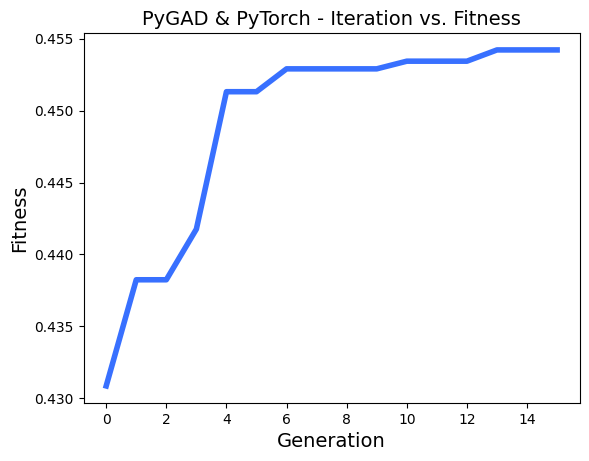

Best solution of MLP6 - number of hidden layers: 4: 
n_embd = 32.0
n_hidden = 68.0
norm_layer = <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
activation = LeakyReLU(negative_slope=0.01)
lr = 0.001 
batch_size = 64.0
optimizer = <class 'torch.optim.adam.Adam'>


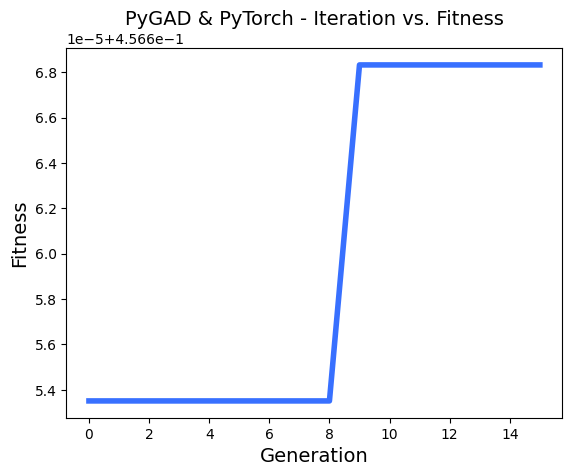

Best solution of MLP7 - number of hidden layers: 3: 
n_embd = 16.0
n_hidden = 78.0
norm_layer = <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
activation = ReLU()
lr = 0.1 
batch_size = 64.0
optimizer = <class 'torch.optim.sgd.SGD'>


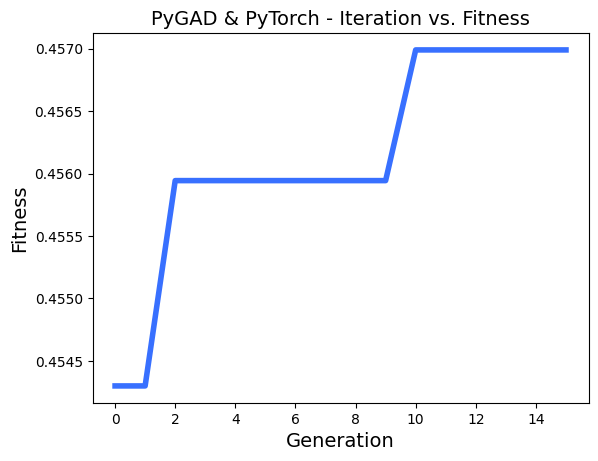

Best solution of MLP8 - number of hidden layers: 2: 
n_embd = 32.0
n_hidden = 76.0
norm_layer = <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
activation = ReLU()
lr = 0.005 
batch_size = 64.0
optimizer = <class 'torch.optim.adam.Adam'>


In [7]:
num_generations = 15 # Number of generations.
num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.
sol_per_pop = 7
mutation_num_genes = 1
keep_elitism = 2
parent_selection_type = "rws" # Type of parent selection.
crossover_type = "single_point"
gene_space = [  
                [8, 16, 32],
                {'low': 16, 'high': 80, 'step': 1},
                [0, 1],
                [0, 1, 2, 3],
                [0.0001, 0.001, 0.005, 0.01, 0.1],
                [16, 32, 64],
                [0, 1],
            ]
num_genes = len(gene_space)

best_fitnesses = []
for i in range(len(inputs)):

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        num_genes=num_genes,
                        sol_per_pop=sol_per_pop,
                        keep_elitism=keep_elitism,
                        parent_selection_type=parent_selection_type,
                        fitness_func=fitness_func_factory(inputs[i]),
                        crossover_type=crossover_type,
                        gene_space=gene_space,
                        mutation_num_genes=mutation_num_genes,
                        )

    # Start the genetic algorithm evolution.
    ga_instance.run()

    ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4);
    solution, best_fitness, _ = ga_instance.best_solution()
    n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = solution
    activation = act_map[activation_num]
    norm_layer = norm_map[norm_layer_num]
    best_fitnesses.append(best_fitness)
    
    print(f"Best solution of MLP{i} - number of hidden layers: {10-i}: \n"
      f"n_embd = {n_embd}\n"
      f"n_hidden = {n_hidden}\n"
      f"norm_layer = {norm_map[norm_layer_num]}\n"
      f"activation = {act_map[activation_num]}\n"
      f"lr = {lr} \n"
      f"batch_size = {batch_size}\n"
      f"optimizer = {optim_map[optimizer_num]}"
    )


| Model | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| --- | --- | --- | --- | --- | --- | --- | --- |
| MLP0 | 32 | 79 | BatchNorm | ReLU | 0.001 | 64 | Adam |
| MLP1 | 32 | 64 | LayerNorm | Tanh | 0.01 | 64 | SDG |
| MLP2 | 8 | 61 | BatchNorm | LekayReLU | 0.1 | 64 | SDG |
| MLP3 | 32 | 75 | BatchNorm | LeakyReLU | 0.001 | 64 | Adam |
| MLP4 | 32 | 59 | BatchNorm | ReLU | 0.1 | 64 | SDG |
| MLP5 | 32 | 68 | LayerNorm | Tanh | 0.01 | 64 | SDG |
| MLP6 | 32 | 68 | BatchNorm | LeakyReLU | 0.001 | 64 | Adam |
| MLP7 | 16 | 78 | BatchNorm | ReLU | 0.1 | 64 | SDG |
| MLP8 | 32 | 76 | BatchNorm | ReLU | 0.005 | 64 | Adam |

### Sprawdzenie efektywności algorytmu genetycznego

Badanie efektywności algorytmu genetycznego wedle kryteriów zaprponowanych w opisie projektu jest trochę problematyczne, ponieważ najefektywniejsze rozwiązanie do którego algorytm miałby dążyć nie jest znane. 

Zamiast tego porównam model o najlepszej funkcji fitness z modelem o losowo dobranych hiperparametrach. Porówne zostaną trzy modele, po jednym z każdej kategorii wielkości inputów.

In [ ]:
inp_fit_pairs = list(zip(inputs, best_fitnesses))
for i in range(len(inputs)):
    if i == 0:
        print("Small Inputs:")
    elif i == 3:
        print("Medium Inputs:")
    elif i == 6:
        print("Large Inputs:")
    print(f"    MLP{i} - fitness: {inp_fit_pairs[i][1]}")

In [ ]:
def draw_hiperparams():
    n_embd = np.random.choice([8, 16, 32])
    n_hidden = np.random.choice(range(16, 80, 1))
    norm_layer_num = np.random.choice([0, 1])
    activation_num = np.random.choice([0, 1, 2, 3])
    lr = np.random.choice([0.0001, 0.001, 0.005, 0.01, 0.1])
    batch_size = np.random.choice([16, 32, 64])
    optimizer_num = np.random.choice([0, 1])
    return n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num

In [ ]:
def training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, model):
    activation = act_map[activation_num]
    norm_layer = norm_map[norm_layer_num]
    bias = True if int(norm_layer_num) == 1 else False
    model = model(vocab_size, n_embd, n_hidden, bias, norm_layer, activation)
    optimizer = optim_map[optimizer_num](params=model.parameters(), lr=lr)
    loss_function = torch.nn.CrossEntropyLoss()
    g = torch.Generator().manual_seed(2147483647)

    step_arr, dev_loss_arr = [], []
    steps = 15000
    start = time.time()
    for step in range(steps):
        if step == 8000:
            optimizer.param_groups[0]['lr'] = lr * 0.7
        elif step == 13000:
            optimizer.param_groups[0]['lr'] = lr * 0.5

        inx = torch.randint(0, training_set.shape[0], (int(batch_size),), generator=g)
        emb = training_set[inx] # grab only those rows from the minibatch 

        optimizer.zero_grad(set_to_none=True)

        # forward pass
        preds = model(emb)
        loss = loss_function(preds, y_training_set[inx])

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        #stats
        if step % 250 == 0:
            dev_loss = get_loss(model, 'dev')
            dev_loss_arr.append(dev_loss)
            step_arr.append(step)

    end = time.time()
    training_time = round(end - start, 2)

    return training_time, step_arr, dev_loss_arr



#### Mały input

In [ ]:
class SmallRandomMLP(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    
    
n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = draw_hiperparams()
rand_train_time, rand_step, rand_loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, SmallRandomMLP)

train_time, step, loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, MLP7)

print(f"Random MLP training time: {rand_train_time} seconds")
print(f"MLP7 training time: {train_time} seconds")
plt.plot(rand_step, rand_loss, label='Random MLP');
plt.plot(step, loss, label='MLP7');
plt.xlabel('Step')
plt.ylabel('Dev Loss')
plt.legend();

#### Średni input

In [ ]:
class MediumRandomMLP(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = draw_hiperparams()
rand_train_time, rand_step, rand_loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, MediumRandomMLP)

train_time, step, loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, MLP4)
 
print(f"Random MLP training time: {rand_train_time} seconds")
print(f"MLP4 training time: {train_time} seconds")
plt.plot(rand_step, rand_loss, label='Random MLP');
plt.plot(step, loss, label='MLP4');
plt.xlabel('Step')
plt.ylabel('Dev Loss')
plt.legend();


#### Duży input

In [ ]:
class BigRandomMLP(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = draw_hiperparams()
rand_train_time, rand_step, rand_loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, BigRandomMLP)

train_time, step, loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, MLP1)

print(f"Random MLP training time: {rand_train_time} seconds")
print(f"MLP1 training time: {train_time} seconds")
plt.plot(rand_step, rand_loss, label='Random MLP');
plt.plot(step, loss, label='MLP1');
plt.xlabel('Step')
plt.ylabel('Dev Loss')
plt.legend();

### Wnioski z Eksperymentu1

### Eksperyment 2

Zmiany w stosunku do algorytmu z Eksperymentu 1:
* parent_selection_type = "rws" ---> parent_selection_type = "sss"
* crossover_type = "single_point" ---> crossover_type = "two_points"
* z grona funkcji aktywacji usunięto sigmoid
* funkcja fitness uległa małej modyfikacji. Tym razem zwracana jest wartość obliczna ze wzoru: 
    * **1.0 / (loss(*zbiór ewaluacyjny*) + (0.001 * training_time))** \
    , gdzie training time to czas przez jaki model był trenowany.

W przypadku algorytmu z Eksperymentu 1 każdy model jest trenowany przez zaledwie 1 epokę (jest to spowodowane ograniczeniami czasowymi). Oznacza to, że modele raczej nie mają szansy na znalezienia globalnego minimum i de facto oceniane są jedynie na podstawie tego, jak szybko są w stanie osiągnąć jak najmniejszą wartość dla funkcji straty w ciągu 1 epoki. Faworyzuje to model o jak większej ilości parametrów i jak największym współczynniku uczenia, ale taki model wcale nie musi być najlepszy w ostatecznym rozrachunku. W celu przeciwdziałania temu dodano parametr training_time, który powinien w jakimś stopniu penalizować większe modele.

In [ ]:
def fitness_func_factory(inp_model):
    def fitness_func(solution, sol_idx):
        n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = solution
        bias = True if int(norm_layer_num) == 1 else False
        activation = act_map[activation_num]
        norm_layer = norm_map[norm_layer_num]
        
        model = inp_model(vocab_size, int(n_embd), int(n_hidden), bias, norm_layer, activation)

        optimizer = optim_map[optimizer_num](params=model.parameters(), lr=lr)

        loss_function = torch.nn.CrossEntropyLoss()
        g = torch.Generator().manual_seed(2147483647)
        steps = 5704
        start = time.time()
        for _ in range(steps):
            inx = torch.randint(0, training_set.shape[0], (int(batch_size),), generator=g)
            emb = training_set[inx] # grab only those rows from the minibatch 

            optimizer.zero_grad(set_to_none=True)

            # forward pass
            preds = model(emb)
            loss = loss_function(preds, y_training_set[inx])

            # backward pass
            loss.backward()

            # update the weights
            optimizer.step()
        end = time.time()
        training_time = round(end - start, 2)
        dev_loss = get_loss(model, 'dev')
        return 1.0 / (dev_loss + (0.001 * training_time))
    
    return fitness_func

In [ ]:
num_generations = 15 # Number of generations.
num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.
sol_per_pop = 7
mutation_num_genes = 1
parent_selection_type = "sss" # Type of parent selection.
crossover_type = "two_points"
gene_space = [  
                [8, 16, 32],
                {'low': 16, 'high': 80, 'step': 1},
                [0, 1],
                [0, 1, 2],
                [0.0001, 0.001, 0.005, 0.01, 0.1],
                [16, 32, 64],
                [0, 1],
            ]
num_genes = len(gene_space)

best_fitnesses = []
for i in range(len(inputs)):

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        num_genes=num_genes,
                        sol_per_pop=sol_per_pop,
                        parent_selection_type=parent_selection_type,
                        fitness_func=fitness_func_factory(inputs[i]),
                        crossover_type=crossover_type,
                        gene_space=gene_space,
                        mutation_num_genes=mutation_num_genes,
                        )

    # Start the genetic algorithm evolution.
    ga_instance.run()

    ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4);
    solution, best_fitness, _ = ga_instance.best_solution()
    n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = solution
    activation = act_map[activation_num]
    norm_layer = norm_map[norm_layer_num]
    best_fitnesses.append(best_fitness)
    
    print(f"Best solution of MLP{i} - number of hidden layers: {10-i}: \n"
      f"n_embd = {n_embd}\n"
      f"n_hidden = {n_hidden}\n"
      f"norm_layer = {norm_map[norm_layer_num]}\n"
      f"activation = {act_map[activation_num]}\n"
      f"lr = {lr}\n"
      f"batch_size = {batch_size}\n"
      f"optimizer = {optim_map[optimizer_num]}"
    )


| Model | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| --- | --- | --- | --- | --- | --- | --- | --- |
| MLP0 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| MLP1 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| MLP2 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| MLP3 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| MLP4 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| MLP5 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| MLP6 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| MLP7 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |
| MLP8 | n_embd | n_hidden | norm_layer_num | activation_num | lr | batch_size | optimizer_num |

### Porównanie efektywności algorytmu genetycznego

Metodologia analogiczna do tej z Eksperymentu 1

In [ ]:
inp_fit_pairs = list(zip(inputs, best_fitnesses))
for i in range(len(inputs)):
    if i == 0:
        print("Small Inputs:")
    elif i == 3:
        print("Medium Inputs:")
    elif i == 6:
        print("Large Inputs:")
    print(f"    MLP{i} - fitness: {inp_fit_pairs[i][1]}")

In [ ]:
def draw_hiperparams():
    n_embd = np.random.choice([8, 16, 32])
    n_hidden = np.random.choice(range(16, 81, 1))
    norm_layer_num = np.random.choice([0, 1])
    activation_num = np.random.choice([0, 1, 2])
    lr = np.random.choice([0.0001, 0.001, 0.005, 0.01, 0.1])
    batch_size = np.random.choice([16, 32, 64])
    optimizer_num = np.random.choice([0, 1])
    return n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num

#### Mały input

In [ ]:
class SmallRandomMLP(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits
    
    
n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = draw_hiperparams()
rand_train_time, rand_step, rand_loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, SmallRandomMLP)

train_time, step, loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, MLP7)

print(f"Random MLP training time: {rand_train_time} seconds")
print(f"MLP7 training time: {train_time} seconds")
plt.plot(rand_step, rand_loss, label='Random MLP');
plt.plot(step, loss, label='MLP7');
plt.xlabel('Step')
plt.ylabel('Dev Loss')
plt.legend();

#### Średni input

In [ ]:
class MediumRandomMLP(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = draw_hiperparams()
rand_train_time, rand_step, rand_loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, MediumRandomMLP)

train_time, step, loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, MLP4)
 
print(f"Random MLP training time: {rand_train_time} seconds")
print(f"MLP4 training time: {train_time} seconds")
plt.plot(rand_step, rand_loss, label='Random MLP');
plt.plot(step, loss, label='MLP4');
plt.xlabel('Step')
plt.ylabel('Dev Loss')
plt.legend();

#### Duży input

In [ ]:
class BigRandomMLP(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden, bias, norm_layer, activation):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, n_hidden, bias=bias), norm_layer(n_hidden), activation,
            nn.Linear(n_hidden, vocab_size, bias=bias), norm_layer(vocab_size)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num = draw_hiperparams()
rand_train_time, rand_step, rand_loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, BigRandomMLP)

train_time, step, loss = training_loop(n_embd, n_hidden, norm_layer_num, activation_num, lr, batch_size, optimizer_num, MLP1)

print(f"Random MLP training time: {rand_train_time} seconds")
print(f"MLP1 training time: {train_time} seconds")
plt.plot(rand_step, rand_loss, label='Random MLP');
plt.plot(step, loss, label='MLP1');
plt.xlabel('Step')
plt.ylabel('Dev Loss')
plt.legend();

### Wnioski z Eksperymentu2

### Kilka próbek z modelu o najlepszych hiperparametrach

In [ ]:
# train
activation = act_map[activation_num]
norm_layer = norm_map[norm_layer_num]
bias = True if int(norm_layer_num) == 1 else False
model = MLP8(vocab_size, n_embd, n_hidden, bias, norm_layer, activation)
optimizer = optim_map[optimizer_num](params=model.parameters(), lr=lr)
loss_function = torch.nn.CrossEntropyLoss()
g = torch.Generator().manual_seed(2147483647)

step_arr, dev_loss_arr = [], []
steps = 30000
start = time.time()
for step in range(steps):
    if step == 18000:
        optimizer.param_groups[0]['lr'] = lr * 0.7
    elif step == 26000:
        optimizer.param_groups[0]['lr'] = lr * 0.5

    inx = torch.randint(0, training_set.shape[0], (int(batch_size),), generator=g)
    emb = training_set[inx] # grab only those rows from the minibatch 

    optimizer.zero_grad(set_to_none=True)

    # forward pass
    preds = model(emb)
    loss = loss_function(preds, y_training_set[inx])

    # backward pass
    loss.backward()

    # update the weights
    optimizer.step()

    #stats
    if step % 250 == 0:
        dev_loss = get_loss(model, 'dev')
        dev_loss_arr.append(dev_loss)
        step_arr.append(step)

end = time.time()
training_time = round(end - start, 2)


In [ ]:
# sample from the model
model.eval()
@torch.no_grad()
def sample(model):
	g = torch.Generator().manual_seed(2147483647 + 10)
	for _ in range(20):
		out = '.' * block_size
		while True:
			x = torch.tensor([str_to_inx[x] for x in out[-block_size:]])
			x = x.view(1, -1)
			logits = model(x)
			probs = F.softmax(logits, dim=1)
			inx = torch.multinomial(probs, num_samples=1, generator=g).item()
			out = out + inx_to_str[inx]
			if inx == 0:
				break
		
		print(out.replace('.', ''))
sample(model)

### Bibliografia

https://www.jstage.jst.go.jp/article/abe/9/0/9_9_225/_pdf/-char/en
https://www.researchgate.net/publication/342408663_Efficient_Hyperparameter_Optimization_in_Deep_Learning_Using_a_Variable_Length_Genetic_Algorithm
https://www.mdpi.com/2079-9292/11/21/3591
https://blog.derlin.ch/genetic-algorithms-with-pygad#heading-rank-selection-rank